<a href="https://colab.research.google.com/github/LOVE-DOCTOR/Sentiment-Analysis-for-Drug-Recommender-System-using-NLP/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SENTIMENT ANALYSIS BASED ON DRUG REVIEWS


## DATA CLEANING

**Importation of required libraries**

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk

import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import re
import string
from string import punctuation

from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB 
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer, WordNetLemmatizer
    
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

from gensim.parsing.preprocessing import remove_stopwords

**Importation of the train and test dataset**

In [9]:
df_train = pd.read_csv("/drugs_train.csv")
#df_test = pd.read_csv("drugs_test.csv")

**Printing the train data**

In [10]:
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


**Printing the first twenty rows of the train file**

In [11]:
df_train.head(20)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [12]:
df_train["drugName"].value_counts()

Levonorgestrel                       3657
Etonogestrel                         3336
Ethinyl estradiol / norethindrone    2850
Nexplanon                            2156
Ethinyl estradiol / norgestimate     2117
                                     ... 
Omnipaque 350                           1
Vontrol                                 1
Ivabradine                              1
Neo-Poly-Dex                            1
Grifulvin V                             1
Name: drugName, Length: 3436, dtype: int64

In [13]:
new_df_cough = df_train.loc[(df_train["drugName"] == "Cough") & (df_train["rating"] > 8), ["uniqueID", "drugName", "condition", "review", "rating", "date", "usefulCount"]]

In [14]:
new_df_cough.reset_index()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount


In [15]:
new_df_cough["drugName"].value_counts()

Series([], Name: drugName, dtype: int64)

In [16]:
new_df_depression = df_train.loc[(df_train["condition"] == "Bipolar Disode") & (df_train["rating"] > 8), ["drugName", "condition", "review", "rating", "usefulCount"]]

In [17]:
new_df_depression.reset_index()

,index,drugName,condition,review,rating,usefulCount


In [18]:
new_df_depression["drugName"].value_counts()

Series([], Name: drugName, dtype: int64)

# DATA VISUALIZATION

**WORDCLOUD VISUALIZATION FOR DRUG NAMES**

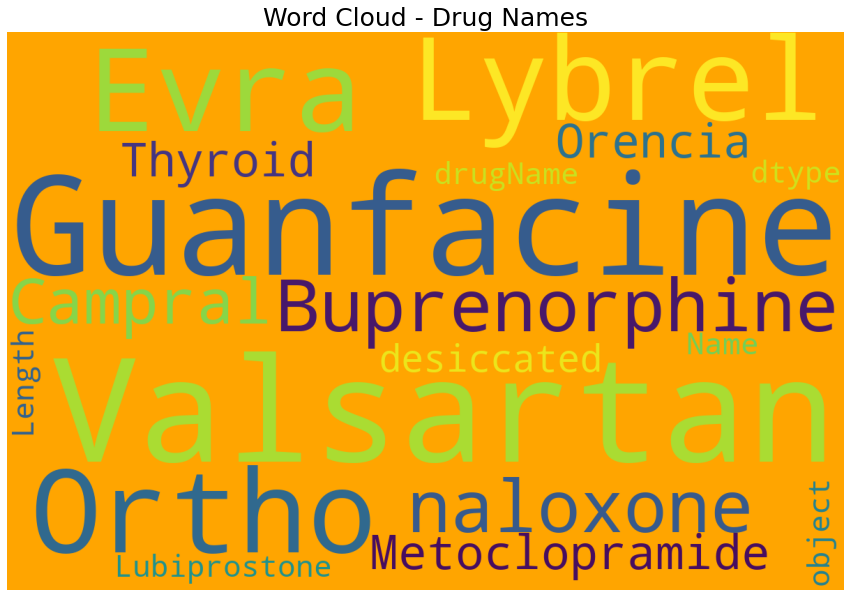

In [19]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'orange', stopwords = stopwords, width = 1200, height = 800).generate(str(df_train['drugName']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud - Drug Names', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

**WORDCLOUD VISUALIZATION FOR REVIEWS**

In [20]:
wordcloud = WordCloud(background_color = "lightblue", stopwords = stopwords, width = 1200, height = 800).generate(str(df_train["review"]))

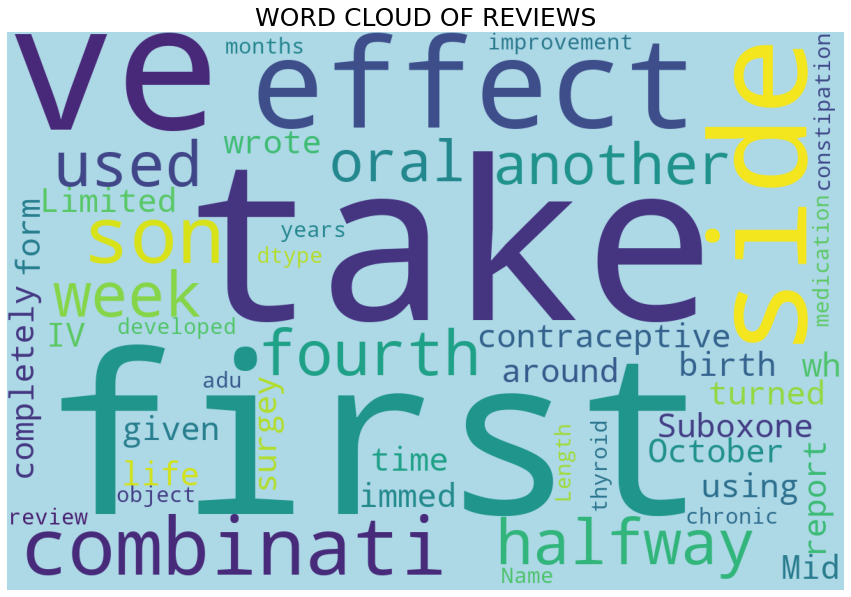

In [21]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## FEATURE ENGINEERING

**Converting the dates to datetime readable by python**

In [22]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [23]:
df_train['day'] =  df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

In [24]:
df_train.drop(["date", "uniqueID"], axis = 1, inplace = True)

**Creating a new column called Review_Sentiment**

In [25]:
df_train.loc[(df_train['rating'] >= 8), 'Review_Sentiment'] = 1
df_train.loc[(df_train['rating'] < 8), 'Review_Sentiment'] = 0

In [26]:
df_train["Review_Sentiment"].value_counts()

1.0    97410
0.0    63887
Name: Review_Sentiment, dtype: int64

In [27]:
df_train

,drugName,condition,review,rating,usefulCount,day,month,year,Review_Sentiment
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,27,20,5,2012,1.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,192,27,4,2010,1.0
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,17,14,12,2009,0.0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,10,3,11,2015,1.0
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,37,27,11,2016,1.0
...,...,...,...,...,...,...,...,...,...
161292,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,125,31,5,2015,1.0
161293,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,34,1,11,2011,0.0
161294,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,35,15,3,2014,0.0
161295,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,79,19,9,2015,1.0


**Wordcloud for positive reviews**

In [28]:
positive_sentiments = " ".join([text for text in df_train['review'][df_train['Review_Sentiment'] == 1]])


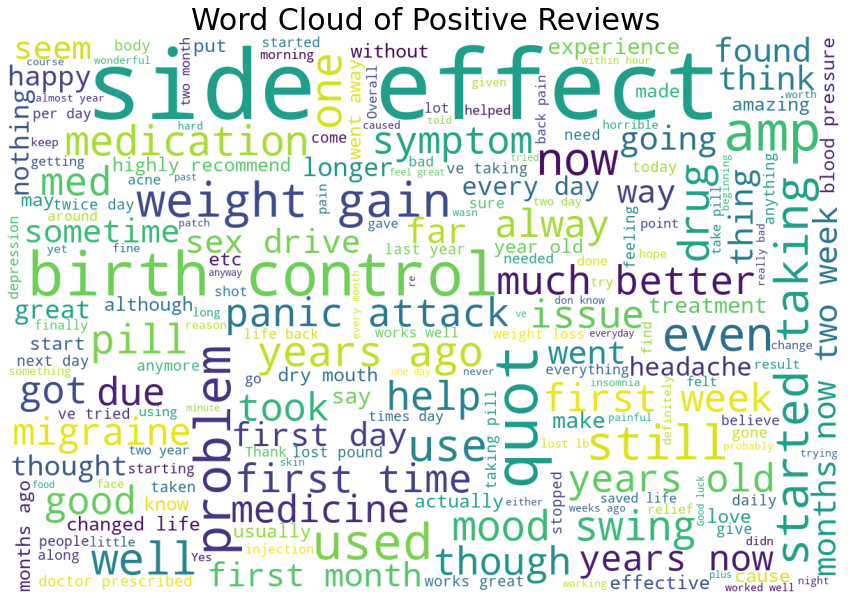

In [29]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

**Wordcloud for negative reviews**

In [30]:
negative_sentiments = " ".join([text for text in df_train['review'][df_train['Review_Sentiment'] == 0]])


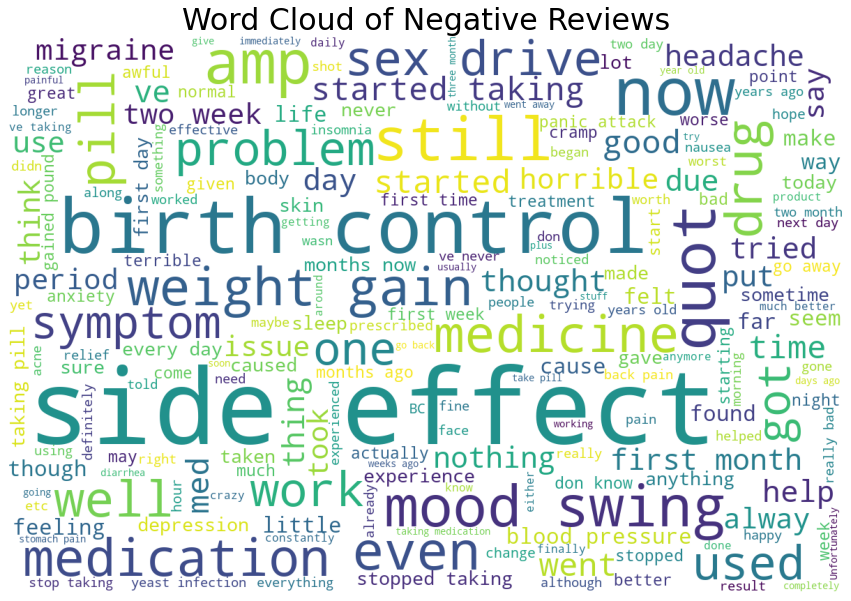

In [31]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# FIXING MIXING VALUES

**Checking the information of the train and test data to check for Datatypes of columns and missing values**

In [ ]:
df_train.info()

In [ ]:
df_test.info()

**Creating a function to append same datatypes to a list and calling the function on the train and test data**

In [ ]:
num_col = []
cat_col = []
def make_num_and_cat(df):
    for i in df:
        if df[i].dtypes == object:
            cat_col.append(i)
        else:
            num_col.append(i)


In [ ]:
make_num_and_cat(df_train)
make_num_and_cat(df_test)

**Checking the lists**

In [ ]:
cat_col

In [ ]:
num_col

**Dropping all the rows with missing values because it's not advisable to fill missing values for condition**

In [ ]:
df_train.dropna(how = "any", inplace = True)
df_test.dropna(how = "any", inplace = True)

**Confirming the rows which contain missing values have been dropped**

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_train["condition"] = df_train["condition"].str.replace('Bipolar Disode', 'Bipolar Disorder')

In [ ]:
df_train["condition"].value_counts().to_frame()



In [ ]:
substring = "users found this comment helpful."

In [ ]:
bytes_first = [j for j in df_train["condition"] if substring in j]

for i in bytes_first:
    df_train.drop(i, axis = 0, inplace = True)

In [ ]:
df_train["condition"].value_counts().to_frame()



In [ ]:
pd. set_option('display.max_rows', 900)

## NLP

In [ ]:
def text_cleaning(review):
    
    
    lower = review.str.lower()
    pattern_remove = lower.str.replace("&#039;", "")
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
   
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$',' ')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    twomore = multiw_remove.str.replace(r'\.{2,}',' ')
    
    #Removing numbers
    numbers = twomore.str.replace(r'\d+',' ')
    
    #Removing special characters
    dataframe = numbers.str.replace(r'[^a-zA-Z0-9.,!?/:;\"\'\s]', ' ')
    return dataframe
    #text = ''.join(c for c in dataframe if c not in punctuation)
    
                          
    
    
                                                                 
    return(dataframe)                                                             
                                                                 

In [ ]:
df_train["review_clean"] = text_cleaning(df_train["review"])

In [ ]:
df_train

**Removing stopwords**

In [ ]:
df_train['review_clean'] = df_train['review_clean'].apply(lambda x: remove_stopwords(x))

In [ ]:
df_train


df_train['review_clean'] = df_train['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [ ]:
lemmatizer = WordNetLemmatizer() 
df_train["review"] = df_train["review"].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))
    

Snow_ball = SnowballStemmer("english")
df_train['review_clean'] = df_train['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

In [ ]:
df_train

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df_train["vaderReviewScore_clean"] = df_train["review_clean"].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [ ]:
df_train

In [ ]:
df_train.dropna(how = "any", inplace = True)
df_test.dropna(how = "any", inplace = True)

In [ ]:
df_train.drop(df_train[df_train['rating'] < 8].index, inplace = True)

In [ ]:
df_train.drop(['review'], axis = 1, inplace = True)

In [ ]:
df_train

In [ ]:
bestADHD = df_train.loc[(df_train["condition"] == 'ADHD'), ['drugName', 'vaderReviewScore_clean']]

In [ ]:
bestADHD.reset_index()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
tfidf = TfidfVectorizer(use_idf = True, 
                        smooth_idf = True, 
                        max_features = 4000,
                        ngram_range = (1, 1))


In [ ]:
x = tfidf.fit_transform(df_train['review_clean']).todense()

In [ ]:
x

In [ ]:
cols = tfidf.get_feature_names()

In [ ]:
cols

In [ ]:
df_train = df_train.drop("review_clean", axis = 1)

df1= pd.DataFrame(x, columns=tfidf.get_feature_names())
df1

In [ ]:
df_train.reset_index(drop = True, inplace = True)

In [ ]:
df_train

In [ ]:
df_train = df_train.join(pd.DataFrame(x, columns=cols), how = 'left', lsuffix='_left', rsuffix='_right')

In [ ]:
df_train

In [ ]:
df_train.info()

In [ ]:
y = df_train['vaderReviewScore_clean']

In [ ]:

X = df_train.drop('vaderReviewScore_clean', axis = 1)


In [ ]:
X

In [ ]:
lab = LabelEncoder()

In [ ]:
df_train["drugName"] = lab.fit_transform(df_train["drugName"])

In [ ]:
df_train["condition_left"] = lab.fit_transform(df_train["condition_left"])

cv = CountVectorizer()



In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
y

In [ ]:
from sklearn.preprocessing import Normalizer

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


sentiment_classifier = Pipeline(steps=[
                                 ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes', MultinomialNB())
                                 ])

normalize = Normalizer()

X_train = normalize.fit_transform(X_train)

X_test = normalize.fit_transform(X_test)

In [ ]:
model = LinearSVC('l2')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
prediction = model.predict(X_test)

In [ ]:
new_pred = pd.DataFrame

In [ ]:
new_pred["Prediction"] = prediction

In [ ]:
print(accuracy_score(y_test, prediction))

cbc = CatBoostClassifier()

cbc.fit(X_train, y_train, cat_features = categorical_var, eval_set=(X_test, y_test), plot=True)